# Iris_ANN

## Libraries

In [ ]:
import torch
print(torch.__version__)

2.3.0+cu121


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchmetrics

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Data-Visualisation & Pre-Processing

In [ ]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
class_names = iris.target_names

In [ ]:
X.shape, y.shape

((150, 4), (150,))

In [ ]:
# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([120, 4]),
 torch.Size([30, 4]),
 torch.Size([120]),
 torch.Size([30]))

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Create a custom Dataset class
class IrisDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
# Create Dataset objects
train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)

In [ ]:
# Define indices
indices = list(range(train_dataset.features.shape[0]))

# Random shuffling of indices
np.random.shuffle(indices)

# Split indices for validation and test
val_idx, train_idx= indices[:20], indices[20:]

In [ ]:
# Define samplers
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=16, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Check the size of each set
print(f"Number of training examples: {len(train_loader.sampler)}")
print(f"Number of validation examples: {len(val_loader.sampler)}")
print(f"Number of test examples: {len(test_loader.sampler)}")

Number of training examples: 100
Number of validation examples: 20
Number of test examples: 30


In [ ]:
def get_classes_distribution(data_loader):
    label_counts = {}

    # Iterate over the DataLoader to collect the labels
    for _, labels in data_loader:
        for label in labels:
            label = label.item()
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

    # Get total number of samples
    total_samples = sum(label_counts.values())

    # Print the count and percentage for each label
    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        print("{}:   {} or {:.2f}%".format(label, count, percent))

get_classes_distribution(train_loader)

2:   35 or 35.00%
1:   30 or 30.00%
0:   35 or 35.00%


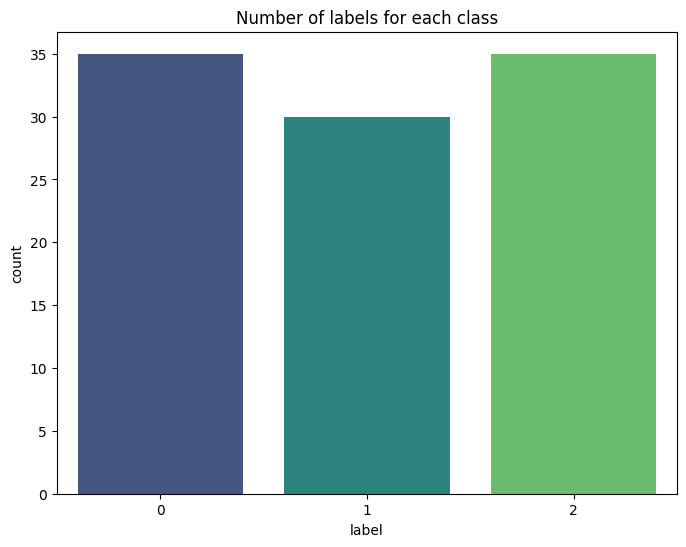

In [ ]:
def plot_class_distribution(data_loader):
    # Collect all labels from the DataLoader
    all_labels = []
    for _, labels in data_loader:
        all_labels.extend(labels.numpy())  # Assuming labels are tensors, convert to numpy

    # Convert the labels to a pandas DataFrame
    labels_df = pd.DataFrame(all_labels, columns=['label'])

    # Plot the distribution using Seaborn
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    g = sns.countplot(data=labels_df, x='label', palette='viridis', ax=ax)
    g.set_title("Number of labels for each class")
    plt.show()

# Example usage with your DataLoader
plot_class_distribution(train_loader)

## Device Agnostics

In [ ]:
# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Explicit EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

## Model-Architecture

In [ ]:
# Define the architecture of the neural network model
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.linear_relu_stack = nn.Sequential(
          nn.Linear(4, 64),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
# Initialize the model
model = ANNModel().to(device)

# Define loss function, optimizer, and learning rate scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Display the model architecture
model

ANNModel(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [ ]:
summary(model, input_size=(1, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             320
           Dropout-2                [-1, 1, 64]               0
              ReLU-3                [-1, 1, 64]               0
            Linear-4                [-1, 1, 32]           2,080
           Dropout-5                [-1, 1, 32]               0
              ReLU-6                [-1, 1, 32]               0
            Linear-7                 [-1, 1, 3]              99
Total params: 2,499
Trainable params: 2,499
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


##Model-Training

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed(42)

In [ ]:
import torch
from torch.utils.data import DataLoader

class DeviceDataLoader:
    def __init__(self, data_loader: DataLoader, device: torch.device):
        self.data_loader = data_loader
        self.device = device

    def __iter__(self):
        self.data_loader_iter = iter(self.data_loader)
        return self

    def __next__(self):
        try:
            X_batch, y_batch = next(self.data_loader_iter)
        except StopIteration:
            raise StopIteration
        return X_batch.to(self.device).float(), y_batch.to(self.device).long()

    def __len__(self):
        return len(self.data_loader)


In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

early_stopping = EarlyStopping(patience=4, verbose=True)

epochs = 100
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)  # Initialize train accuracy

  for X_batch, y_batch in train_loader:
    y_pred = model(X_batch)

    loss = loss_fn(y_pred, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc.update(y_pred, y_batch)

  train_losses.append(running_loss / len(train_loader))
  train_accuracies.append(train_acc.compute().item())

  model.eval()
  lossu = 0.0
  val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)

  with torch.inference_mode():
    for X_val, y_val in val_loader:
      y_val_pred = model(X_val)
      loss = loss_fn(y_val_pred, y_val)
      lossu += loss.item()

      val_acc.update(y_val_pred, y_val)

  val_losses.append(lossu / len(val_loader))
  val_accuracies.append(val_acc.compute().item())

  if epoch % 5 == 0:
    print(f"Epoch: {epoch}, Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}")

  # scheduler.step()

  early_stopping(val_losses[-1])
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch: 0, Loss: 1.0344475507736206, Val Loss: 1.0102698802947998, Train Acc: 0.5699999928474426, Val Acc: 0.699999988079071
Epoch: 5, Loss: 0.6478406105722699, Val Loss: 0.8002412021160126, Train Acc: 0.8100000023841858, Val Acc: 0.699999988079071
EarlyStopping counter: 1 out of 4
Epoch: 10, Loss: 0.42587470156805857, Val Loss: 0.5237928330898285, Train Acc: 0.8500000238418579, Val Acc: 0.75
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
Epoch: 15, Loss: 0.25099251818444046, Val Loss: 0.37071700394153595, Train Acc: 0.9399999976158142, Val Acc: 0.8999999761581421
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
Epoch: 20, Loss: 0.21692206391266414, Val Loss: 0.17272771522402763, Train Acc: 0.9399999976158142, Val Acc: 0.949999988079071
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
Epoch: 25, Loss: 0.1635019342814173, Val Loss: 0.12658839859068394, Train Acc:

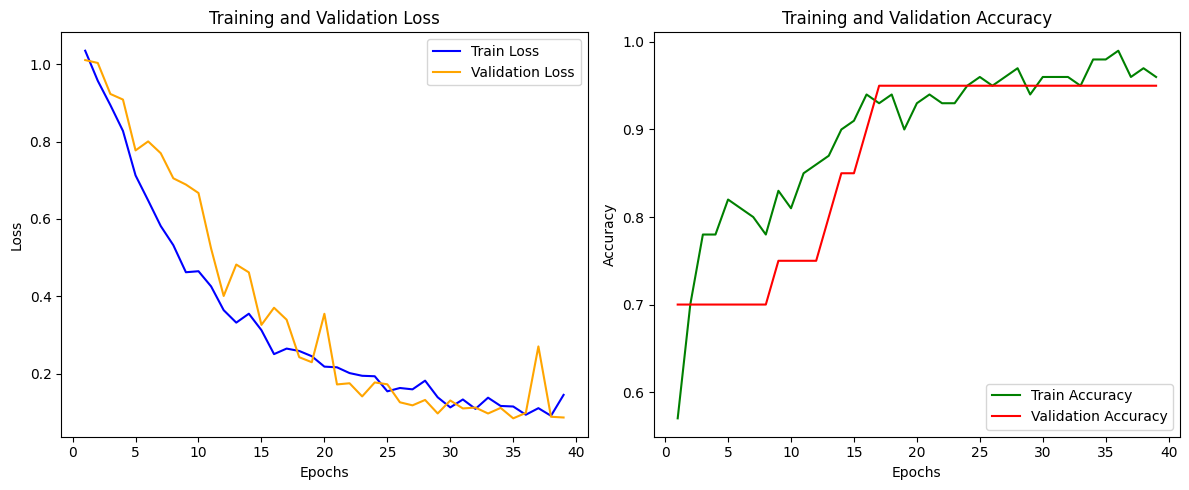

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the loss curves
ax1.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='blue')
ax1.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='upper right')

# Plot the accuracy curves
ax2.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy', color='green')
ax2.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

* Hence It is always to the best option
* Considering the train data is mearly 120
* neural networks are not good when data is low
* rather conventional ml algorithms work much better

##Model-Evaluation

In [ ]:
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
model.eval()
lossu = 0.0
test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)

with torch.inference_mode():
  for X_test, y_test in test_loader:
    y_test_pred = model(X_test)
    loss = loss_fn(y_test_pred, y_test)
    lossu += loss.item()
    test_acc.update(y_test_pred, y_test)

print(f"Test Loss: {lossu / len(test_loader)}")
print(f"Test Accuracy: {test_acc.compute().item()}")

Test Loss: 0.05513891391456127
Test Accuracy: 1.0


In [ ]:
model.eval()
y_test_all = []
y_test_pred_all = []

with torch.inference_mode():
  for X_test, y_test in test_loader:
    y_test_all.append(y_test)
    y_test_pred = model(X_test)
    y_test_pred = torch.softmax(y_test_pred, dim=1)
    y_test_pred_all.append(y_test_pred)

y_test_all = torch.cat(y_test_all).cpu().numpy()
y_test_pred_all = torch.cat(y_test_pred_all).cpu().numpy()

In [ ]:
y_test_pred_all_ = []
for i in y_test_pred_all:
  y_test_pred_all_.append(np.argmax(i))

In [ ]:
# Generate the classification report
report = classification_report(y_test_all, y_test_pred_all_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



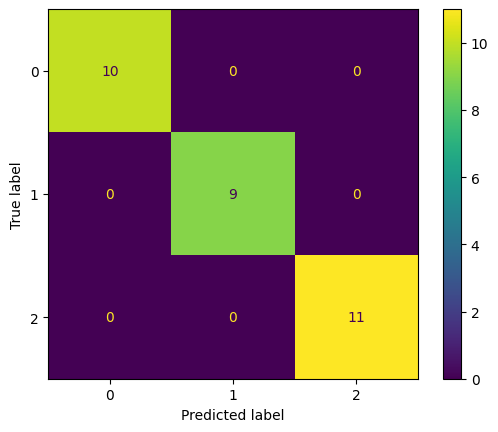

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_all, y_test_pred_all_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()